In [1]:
%load_ext jbmagics
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2

Exception reporting mode: Minimal


# Example: Extraction-Injection System

This example demonstrates how `pymf6` can be used to control the rate of an extraction well and an 
injection in lockstep.
The injection rate is the same as the extraction rate,
i.e. `extraction_rate == -injection_rate`.
There are two constrains:

1. The water level of the extraction well should NOT fall below a certain level.
2. The water level of the injection well should NOT rise above a certain level.

We import our helper functions 
(see [Example: Head Controlled Well](../head_controlled_wellHead_Controlled_Well.ipynb) 
`doc/head_controlled_wellHead_Controlled_Well.ipynb` for details):

In [2]:
from tools.make_model import make_input, run_simulation
from tools.plotting import show_heads, show_well_head
from tools.base_model import make_model_data

We setup a new model, based on the base model:

In [3]:
model_path = r'models\mf6'
name = 'sysinoutwel'
wel_coordsout = (0, 6, 6)
wel_coordsin = (0, 2, 2)
wel_qout = [-0.05, -0.5, -0.05]
wel_qin = [x * -1 for x in wel_qout]

specific_model_data = {
    'model_path': model_path,
    'name': name,
    'chd': [
        [(0, 0, 0), 0.7],
        [(0, 9, 9), 0.8]
    ],
    'sy': 0.3,
    'wells': {'wel_out': {'q': wel_qout, 'coords': wel_coordsout},
              'wel_in': {'q': wel_qin, 'coords': wel_coordsin},
             }
}

model_data = make_model_data(specific_model_data)

We use two wells, one for extraction and for injection that have the same rate,
but with inverse sign.
The values of the boundary conditions in the corners are `0.7` (upper left) and
`0.8` (lower right).

We create the input files a our model:

In [4]:
make_input(model_data)

and run the simulation:

In [5]:
run_simulation(model_path=model_path)

The water level at the end of the third stress period, 
i.e. with lowest water level at the extraction and the highest water level at the injection well,
shows how the system looks like:

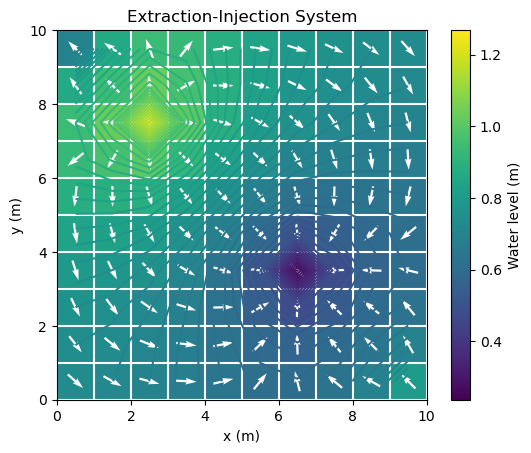

In [6]:
show_heads(model_path=model_path, name=name, title='Extraction-Injection System');

This is the water level over time at the:

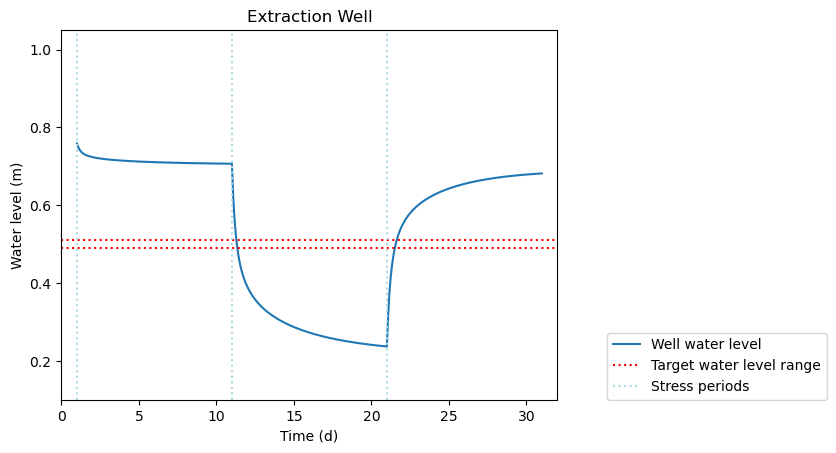

In [7]:
show_well_head(
    title='Extraction Well',
    wel_coords=wel_coordsout, 
    model_data=model_data,
    y_start=0.1,
    lower_head_limit=0.49,
    upper_head_limit=0.51,
);

and at the injection well:

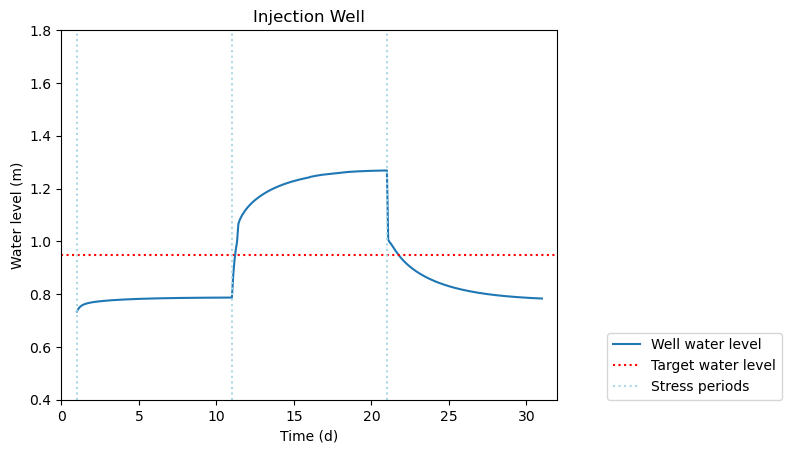

In [8]:
show_well_head(
    title='Injection Well',
    wel_coords=wel_coordsin,
    model_data=model_data,
    y_start=0.4,
    y_end=1.8,
    upper_head_limit=0.95);

Starting from day 11, 
i.e. with beginning of stress period 3,
the water level of the injection well is above ground.
This means the groundwater would appear at the surface.
We want to prevent this.
Therefore, we create a the same model input data,
but in a different directory:

In [9]:
model_path = r'models\pymf6'

specific_model_data = {
    'model_path': model_path,
}


pymf6_model_data = make_model_data(specific_model_data, 
                                   base_model_data=model_data)

make_input(pymf6_model_data)

We create a control program:

In [10]:
%include extraction_injection.py

```python
from pymf6.mf6 import MF6

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    head = mf6.vars['SLN_1/X']
    wel_index_in = 22
    wel_index_out = 66
    tolerance = 0.01
    head_limit_out = 0.5
    head_limit_in = 0.95
    upper_limit_in = head_limit_in + tolerance
    upper_limit_out = head_limit_out + tolerance
    lower_limit_out = head_limit_out - tolerance
    wel_out, wel_in = mf6.vars['SYSINOUTWEL/WEL_0/BOUND']
    pumping_reduced = False
    for step in mf6.steps():
        if step >= 11 and step < 21:
            if ((head[wel_index_in] > upper_limit_in) or
                (head[wel_index_out] < lower_limit_out)):
                wel_out[0] = wel_out[0] * 0.99
                pumping_reduced = True
            elif pumping_reduced and head[wel_index_out] > upper_limit_out:
                wel_out[0] = wel_out[0] * 1.01
            wel_in[0] = -wel_out[0]


if __name__ == '__main__':
    run_model(r'models/pymf6/mfsim.nam')
```


The control is based on multiple criteria:

1. We only influence the system in stress period 3,
   i.e. between day 11 and 21.
2. If water level of the injection well rises above the injection upper limit,
   or the water level in the extraction falls below the extraction lower limit,
   we reduce the pumping by 10%.
3. If we reduce the pumping before and the water level in the extraction well
   is above the extraction upper limit,
   we increase the pumping by 10%.

We run our model in under the control of `pymf6`:

In [11]:
import sys
from subprocess import run

In [12]:
run([sys.executable, 'extraction_injection.py'], check=True)

CompletedProcess(args=['/Users/mike/miniconda3/envs/modflowapi/bin/python', 'extraction_injection.py'], returncode=0)

Now, the water level at the injection well mainly stays at the desired water level:

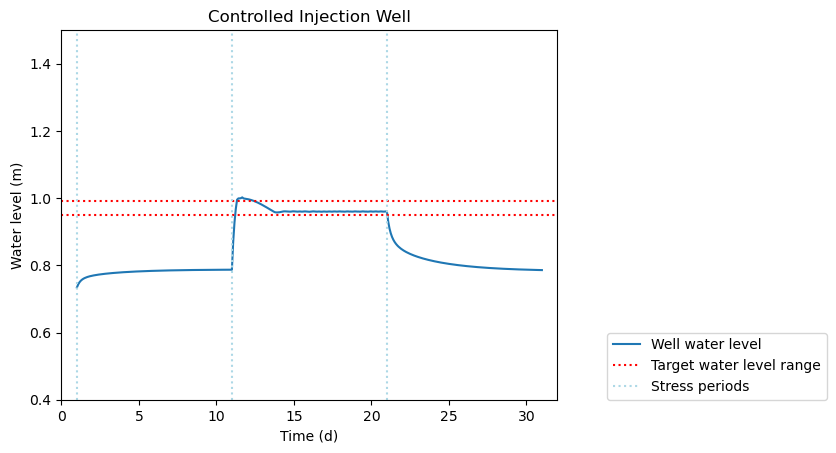

In [13]:
show_well_head(
    title='Controlled Injection Well',
    wel_coords=wel_coordsin,
    model_data=pymf6_model_data,
    y_start=0.4, y_end=1.5,
    lower_head_limit=0.95,
    upper_head_limit=0.99,
);

There is small swing of water level above the limit at day 11.
This is due to very sharp increase of the injection by a factor of 10,
that cannot be totally reduced by a 1% change per iteration.
But the water level is still within the desired rang between 0.95 and 0.99 m.

Now, the water level of the extraction well does not fall lower limit:

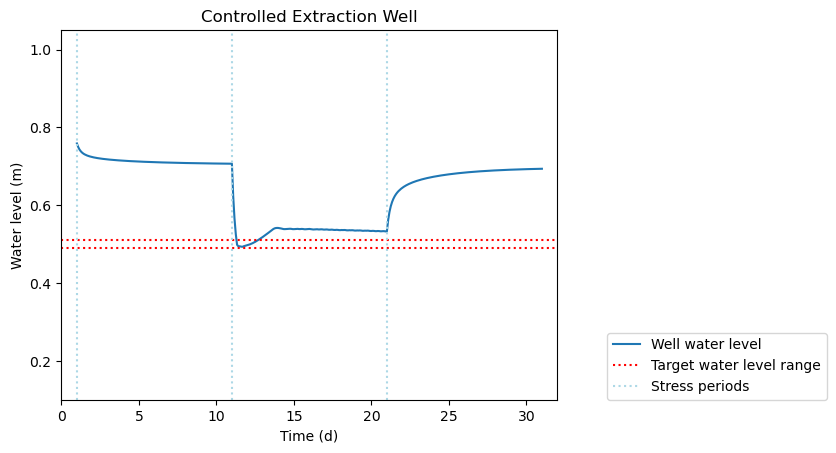

In [14]:
show_well_head(
    title='Controlled Extraction Well',
    wel_coords=wel_coordsout, 
    model_data=pymf6_model_data, 
    y_start=0.1,
    lower_head_limit=0.49,
    upper_head_limit=0.51,
);

The water level is not within the desired limits.
Since we have multiple criteria, this it not achievable.
We focus on the injection well.

Let' smooth out the swing of water level of injection well by reducing the pumping rate
right the begin of stress period 3:

In [15]:
%include extraction_injection_smooth.py

```python
from pymf6.mf6 import MF6

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    head = mf6.vars['SLN_1/X']
    wel_index_in = 22
    wel_index_out = 66
    tolerance = 0.01
    head_limit_out = 0.5
    head_limit_in = 0.95
    upper_limit_in = head_limit_in + tolerance
    upper_limit_out = head_limit_out + tolerance
    lower_limit_out = head_limit_out - tolerance
    wel_out, wel_in = mf6.vars['SYSINOUTWEL/WEL_0/BOUND']
    pumping_reduced = False
    init_reduce = True
    init_reduce_amount = 1
    for step in mf6.steps():
        if step >= 11 and step < 21:
            if init_reduce and  step < 11.1:
                wel_out[0] = wel_out[0] * 0.9
                init_reduce_amount *= 0.9
                if init_reduce_amount < 0.5:
                    init_reduce = False
            if ((head[wel_index_in] > upper_limit_in) or
                (head[wel_index_out] < lower_limit_out)):
                wel_out[0] = wel_out[0] * 0.99
                pumping_reduced = True
            elif pumping_reduced and head[wel_index_out] > upper_limit_out:
                wel_out[0] = wel_out[0] * 1.01
            wel_in[0] = -wel_out[0]


if __name__ == '__main__':
    run_model(r'models/pymf6/mfsim.nam')
```


Now, the water level looks much better:

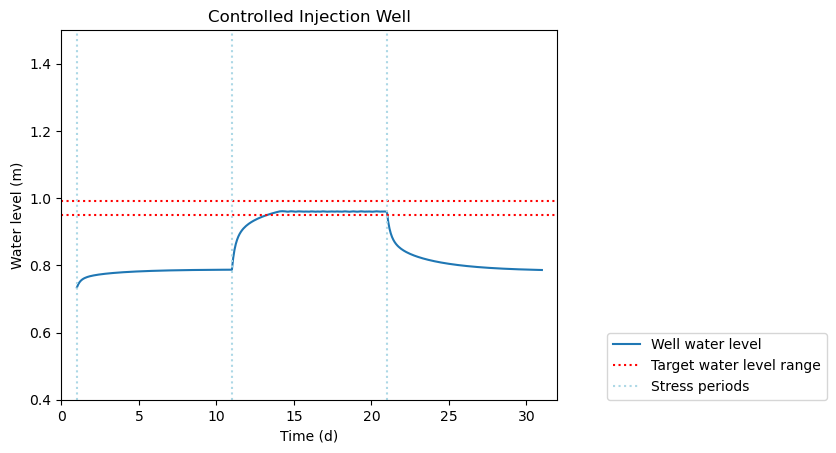

In [16]:
run([sys.executable, 'extraction_injection_smooth.py'], check=True)
show_well_head(
    title='Controlled Injection Well',
    wel_coords=wel_coordsin, 
    model_data=pymf6_model_data, 
    y_start=0.4, y_end=1.5,
    lower_head_limit=0.95,
    upper_head_limit=0.99,
);